# b factor normalization check

In [ ]:
from Bio import PDB

parser = PDB.PDBParser()

import requests

io = PDB.PDBIO()


# wrap that in a function
def extract_chain_from_pdb(pdb_code, chain):
    """
    Extracts a specific chain from a PDB file and writes it to a new file.

    Parameters:
    - input_path: Path to the original PDB file.
    - output_path: Path to save the filtered PDB file.
    - chain_id: The chain identifier to keep (e.g., 'A').
    """

    pdb_code = pdb_code.lower()
    url = f"https://files.rcsb.org/download/{pdb_code}.pdb"
    response = requests.get(url)

    DATA_DIR = "../datasets"

    if response.status_code == 200:
        full_pdb_path = f"{DATA_DIR}/test_val_full_pdbs/{pdb_code}.pdb"
        chain_pdb_path = f"{DATA_DIR}/test_val_chain_pdbs/{pdb_code}_chain{chain}.pdb"
        with open(full_pdb_path, 'w') as file:
            file.write(response.text)
    else:
        print(f"Failed to download PDB file for code: {pdb_code}")
        return pdb_code
    try:
        parser = PDB.PDBParser()
        structure = parser.get_structure("protein", full_pdb_path)

        io = PDB.PDBIO()
        io.set_structure(structure[0][chain_id])  # Select specified chain
        io.save(chain_pdb_path)  # Save to new file
    except Exception as e:
        print(f"Error processing {pdb_code}: {e}")
        return pdb_code
    return 3

In [10]:
import numpy as np
from io import StringIO
import requests

import matplotlib.pyplot as plt

def get_bfactor_stats(pdb_code, chain_id=None):
    """
    Downloads a PDB file, extracts B-factor values, and plots statistics.

    Parameters:
    - pdb_code: PDB code of the protein.
    - chain_id: Optional chain identifier to filter atoms.
    """
    pdb_code = pdb_code.lower()
    url = f"https://files.rcsb.org/download/{pdb_code}.pdb"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to download PDB file for code: {pdb_code}")
        return

    # Parse structure from string (no file saving)
    structure = parser.get_structure("protein", StringIO(response.text))

    b_factors = []
    for model in structure:
        for chain in model:
            if chain_id and chain.id != chain_id:
                continue
            for residue in chain:
                for atom in residue:
                    b_factors.append(atom.get_bfactor())

    if not b_factors:
        print("No B-factors found.")
        return

    b_factors = np.array(b_factors)
    print(f"B-factor statistics for {pdb_code} (chain {chain_id if chain_id else 'all'}):")
    print(f"Mean: {b_factors.mean():.2f}")
    print(f"Std: {b_factors.std():.2f}")
    print(f"Min: {b_factors.min():.2f}")
    print(f"Max: {b_factors.max():.2f}")
    # put statistics on the plot
    plt.figure(figsize=(10, 6))
    plt.axvline(b_factors.mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {b_factors.mean():.2f}')
    plt.axvline(b_factors.mean() + b_factors.std(), color='orange', linestyle='dashed', linewidth=1, label=f'Std: {b_factors.std():.2f}')
    plt.axvline(b_factors.mean() - b_factors.std(), color='orange', linestyle='dashed', linewidth=1)
    plt.axvline(b_factors.min(), color='green', linestyle='dashed', linewidth=1, label=f'Min: {b_factors.min():.2f}')
    plt.axvline(b_factors.max(), color='blue', linestyle='dashed', linewidth=1, label=f'Max: {b_factors.max():.2f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.hist(b_factors, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"B-factor Distribution ({pdb_code}, chain {chain_id if chain_id else 'all'})")
    plt.xlabel("B-factor")
    plt.ylabel("Count")
    plt.show()
    return b_factors

In [50]:
path = "/home/t-alptartici/inverse-folding/datasets/AF-A0A001-F1-model_v4.cif"
get_alphafold_plddt_stats(path)

(tensor([58.0000, 60.9100, 60.4700, 64.1900, 74.3800, 83.1900, 86.8100, 86.5600,
         90.5000, 92.3100, 91.5600, 92.3100, 93.8100, 94.6200, 94.1900, 94.8100,
         95.5600, 95.0600, 94.4400, 94.3800, 95.1200, 94.2500, 94.2500, 95.5000,
         95.8800, 95.1900, 94.3800, 95.1200, 93.8800, 91.5600, 93.9400, 92.1900,
         91.5000, 90.0000, 89.2500, 86.6900, 82.3100, 67.6200, 70.8800, 65.3800,
         70.3800, 83.0600, 87.2500, 89.2500, 90.3100, 89.3800, 91.3100, 92.5000,
         92.8800, 93.0000, 93.5600, 94.8100, 94.5000, 94.0000, 94.6900, 94.8800,
         94.3800, 93.8100, 94.0600, 91.5600, 90.3100, 89.8800, 88.3800, 86.6200,
         85.1900, 86.3800, 85.8100, 87.8100, 85.6200, 87.5600, 89.4400, 88.3100,
         88.8800, 90.0600, 89.9400, 87.7500, 85.8100, 89.3100, 87.1200, 83.4400,
         83.1200, 86.1900, 83.3100, 77.1900, 77.6200, 77.3800, 73.6200, 69.5000,
         69.0600, 71.2500, 65.3100, 56.6600, 51.0300, 49.5000, 47.9400, 49.1900,
         48.3400, 50.6600, 5

In [49]:
import torch
from Bio.PDB import MMCIFParser

def get_alphafold_plddt_stats(cif_path):
    """
    Extracts pLDDT scores from an AlphaFold2 CIF file and returns the scores and statistics.

    Args:
        cif_path (str): Path to the AlphaFold2 CIF file.

    Returns:
        plddt_scores (torch.Tensor): Tensor of pLDDT scores for each residue.
        stats (dict): Dictionary with mean, std, min, max of pLDDT scores.
    """
    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure("prot", cif_path)
    model = structure[0]
    chain = next(model.get_chains())
    plddt_scores = []
    for res in chain:
        if not res.has_id("CA"):
            continue
        plddt_scores.append(res["CA"].get_bfactor())
    plddt_scores = torch.tensor(plddt_scores, dtype=torch.float)
    stats = {
        "mean": float(plddt_scores.mean()),
        "std": float(plddt_scores.std()),
        "min": float(plddt_scores.min()),
        "max": float(plddt_scores.max())
    }
    return plddt_scores, stats

In [63]:


def plot_plddt_comparison_with_stats(path):
    """
    Plots side-by-side histograms of raw and transformed B-factors for a given PDB code and chain,
    with statistics printed and shown on the raw plot.
    """
    plddt, stats = get_alphafold_plddt_stats(path)
    if plddt is None:
        return
    normalized_plddt = normalize_uncertainty(plddt, version='mcun', type='plddt')

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Raw B-factor histogram with stats
    axes[0].hist(plddt, bins=30, color='skyblue', edgecolor='black')
    axes[0].axvline(stats["mean"], color='red', linestyle='dashed', linewidth=1, label=f'Mean: {stats["mean"]:.2f}')
    axes[0].axvline(stats["mean"] + stats["std"], color='orange', linestyle='dashed', linewidth=1, label=f'Std: {stats["std"]:.2f}')
    axes[0].axvline(stats["mean"] - stats["std"], color='orange', linestyle='dashed', linewidth=1)
    axes[0].axvline(stats["min"], color='green', linestyle='dashed', linewidth=1, label=f'Min: {stats["min"]:.2f}')
    axes[0].axvline(stats["max"], color='blue', linestyle='dashed', linewidth=1, label=f'Max: {stats["max"]:.2f}')
    axes[0].set_title(f"Raw pLDDT Histogram")
    axes[0].set_xlabel("pLDDT")
    axes[0].set_ylabel("Count")
    axes[0].grid(True)
    axes[0].legend()
    print(f"pLDDT statistics")
    print(f"Mean: {stats['mean']:.2f}")
    print(f"Std: {stats['std']:.2f}")
    print(f"Min: {stats['min']:.2f}")
    print(f"Max: {stats['max']:.2f}")

    # Transformed pLDDT histogram
    axes[1].hist(normalized_plddt, bins=30, color='purple', edgecolor='black')
    axes[1].set_title(f"Transformed pLDDT Histogram ({path.split('/')[-1]}")
    axes[1].set_xlabel("Transformed pLDDT")
    axes[1].set_ylabel("Count")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

pLDDT statistics
Mean: 84.68
Std: 16.25
Min: 26.41
Max: 97.75


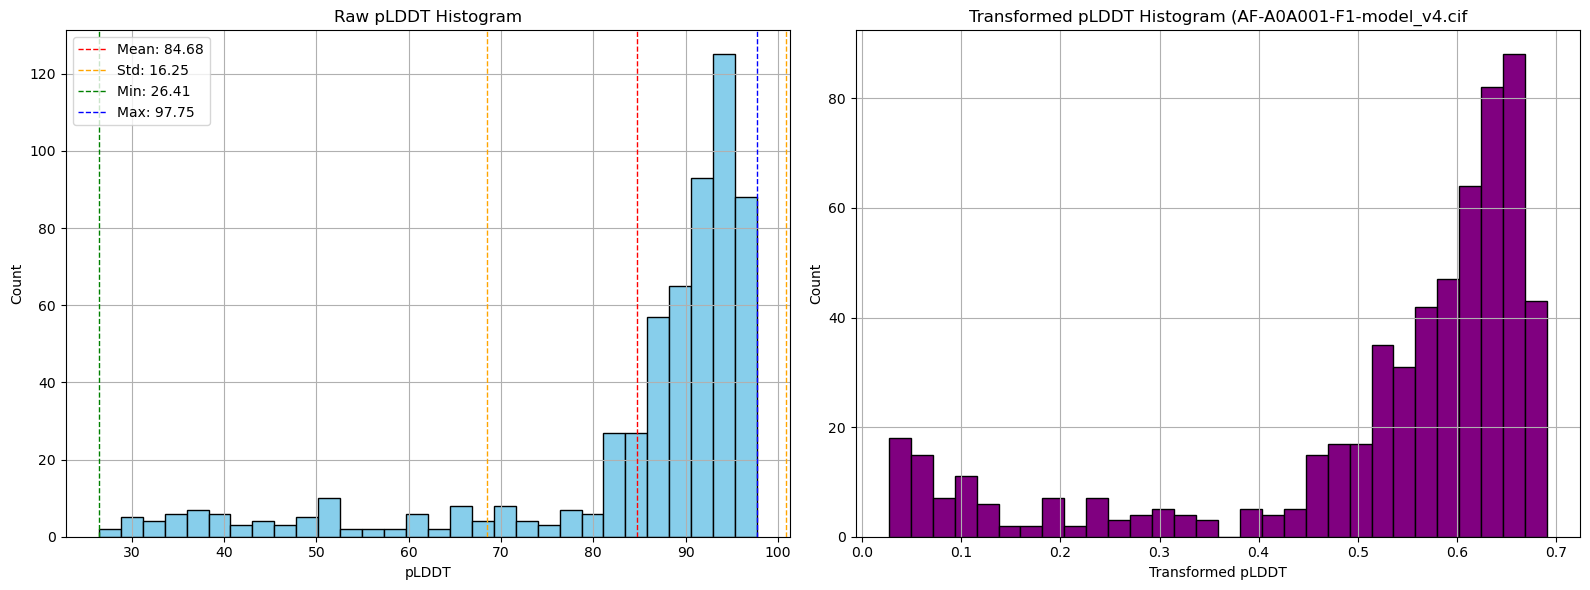

In [64]:
plot_plddt_comparison_with_stats(path)


In [ ]:
def get_bfactor_stats_only(pdb_code, chain_id=None):
    """
    Downloads a PDB file, extracts B-factor values, and returns statistics and values.

    Parameters:
    - pdb_code: PDB code of the protein.
    - chain_id: Optional chain identifier to filter atoms.
    """
    pdb_code = pdb_code.lower()
    url = f"https://files.rcsb.org/download/{pdb_code}.pdb"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to download PDB file for code: {pdb_code}")
        return None, None

    structure = parser.get_structure("protein", StringIO(response.text))

    b_factors = []
    for model in structure:
        for chain in model:
            if chain_id and chain.id != chain_id:
                continue
            for residue in chain:
                for atom in residue:
                    b_factors.append(atom.get_bfactor())

    if not b_factors:
        print("No B-factors found.")
        return None, None

    b_factors = np.array(b_factors)
    stats = {
        "mean": b_factors.mean(),
        "std": b_factors.std(),
        "min": b_factors.min(),
        "max": b_factors.max()
    }
    return b_factors, stats

def plot_bfactor_comparison_with_stats(pdb_code, chain_id=None):
    """
    Plots side-by-side histograms of raw and transformed B-factors for a given PDB code and chain,
    with statistics printed and shown on the raw plot.
    """
    b_factors, stats = get_bfactor_stats_only(pdb_code, chain_id)
    if b_factors is None:
        return
    normalized_b = normalize_uncertainty(b_factors)  

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Raw B-factor histogram with stats
    axes[0].hist(b_factors, bins=30, color='skyblue', edgecolor='black')
    axes[0].axvline(stats["mean"], color='red', linestyle='dashed', linewidth=1, label=f'Mean: {stats["mean"]:.2f}')
    axes[0].axvline(stats["mean"] + stats["std"], color='orange', linestyle='dashed', linewidth=1, label=f'Std: {stats["std"]:.2f}')
    axes[0].axvline(stats["mean"] - stats["std"], color='orange', linestyle='dashed', linewidth=1)
    axes[0].axvline(stats["min"], color='green', linestyle='dashed', linewidth=1, label=f'Min: {stats["min"]:.2f}')
    axes[0].axvline(stats["max"], color='blue', linestyle='dashed', linewidth=1, label=f'Max: {stats["max"]:.2f}')
    axes[0].set_title(f"Raw B-factor Histogram ({pdb_code}, chain {chain_id if chain_id else 'all'})")
    axes[0].set_xlabel("B-factor")
    axes[0].set_ylabel("Count")
    axes[0].grid(True)
    axes[0].legend()
    print(f"B-factor statistics for {pdb_code} (chain {chain_id if chain_id else 'all'}):")
    print(f"Mean: {stats['mean']:.2f}")
    print(f"Std: {stats['std']:.2f}")
    print(f"Min: {stats['min']:.2f}")
    print(f"Max: {stats['max']:.2f}")

    # Transformed B-factor histogram
    axes[1].hist(normalized_b, bins=30, color='purple', edgecolor='black')
    axes[1].set_title(f"Transformed B-factor Histogram ({pdb_code}, chain {chain_id if chain_id else 'all'})")
    axes[1].set_xlabel("Transformed B-factor")
    axes[1].set_ylabel("Count")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

/home/t-alptartici/miniconda3/envs/inv_fold/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3672.
  warnings.warn(
/home/t-alptartici/miniconda3/envs/inv_fold/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3699.
  warnings.warn(


B-factor statistics for 2QG3 (chain A):
Mean: 27.65
Std: 9.56
Min: 2.00
Max: 67.24


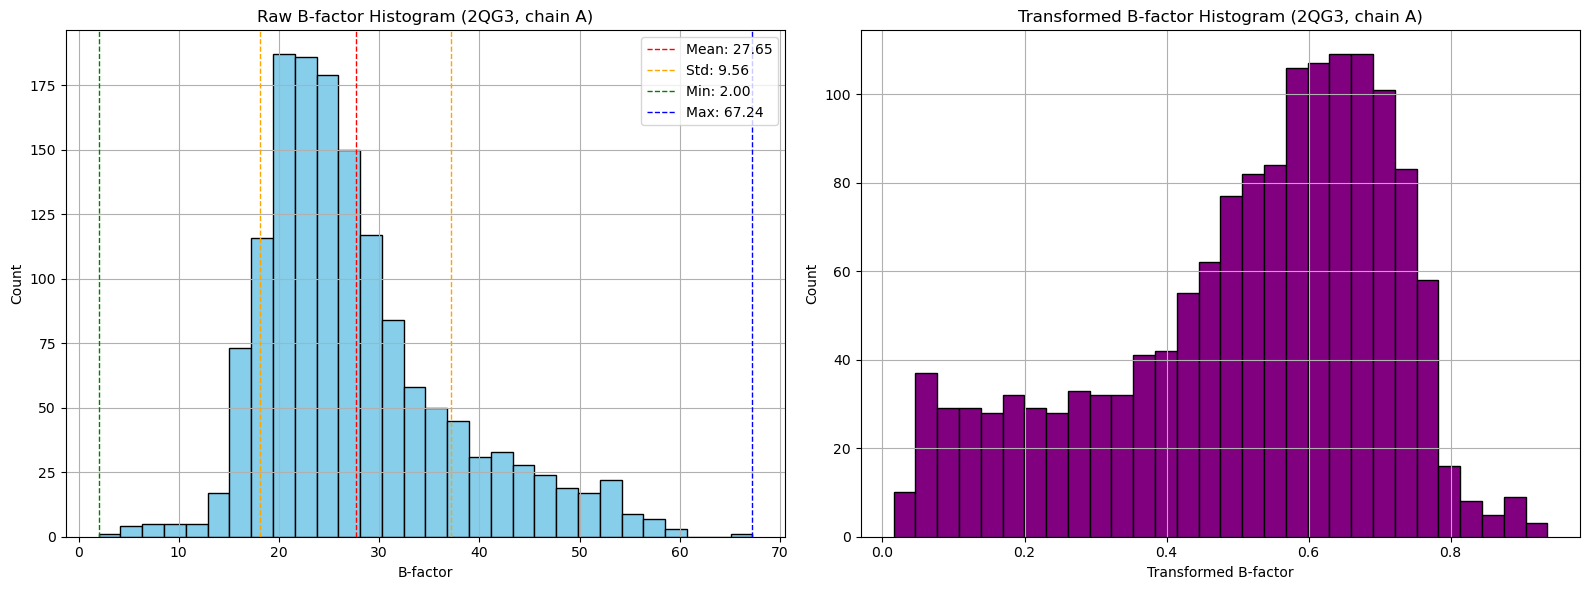

In [ ]:
plot_bfactor_comparison_with_stats('2QG3', 'A')


B-factor statistics for 3VLA (chain A):
Mean: 12.88
Std: 7.96
Min: 3.83
Max: 52.65


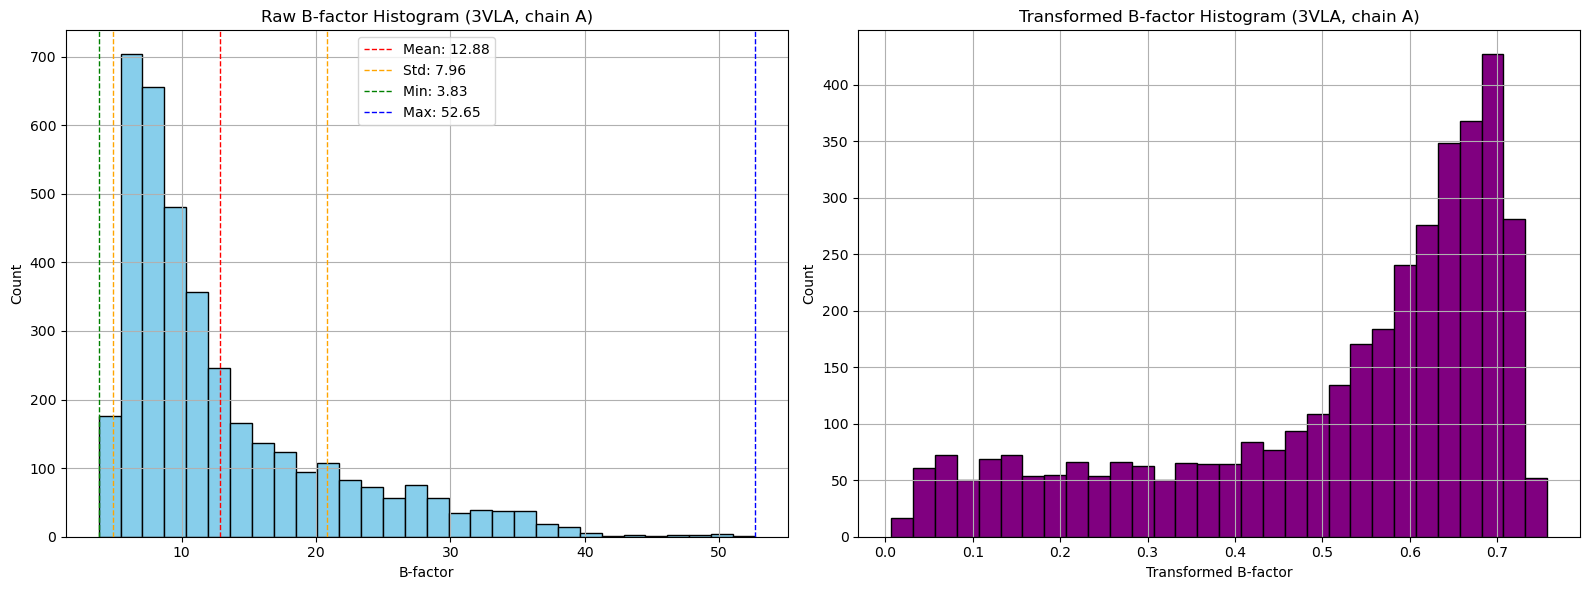

In [33]:
plot_bfactor_comparison_with_stats('3VLA', 'A')

In [21]:
def normalize_uncertainty(input, version='mcun', type='b_factor'):
    """
    Normalizes B-factors using either mean-center unit-norm + sigmoid ('mcun', default)
    or min-max normalization + sigmoid ('minmax').

    Parameters:
    - b_factors: numpy array of B-factors
    - version: 'mcun' or 'minmax'
    """
    input = np.array(input)
    if version == 'minmax':
        b_min = np.min(input)
        b_max = np.max(input)
        norm = (input - b_min) / (b_max - b_min)
        sigmoid = 1 / (1 + np.exp(-norm))
    else:  # 'mcun'
        mean = np.mean(input)
        std = np.std(input)
        if std == 0:
            norm = input - mean
        else:
            norm = (input - mean) / std
        sigmoid = 1 / (1 + np.exp(-norm))
        
    if type == 'b_factor':
        normalized = 1 - sigmoid
    else:
        normalized = sigmoid
    return normalized



# pickle inspection

In [1]:
import pickle

with open("../datasets/cath-4.2/chain_set_map_with_b_factors.pkl", "rb") as f:
    chain_set_map_with_b_factors = pickle.load(f)

with open("../datasets/cath-4.2/chain_set_map.pkl", "rb") as f:
    chain_set_map = pickle.load(f)

In [34]:
protein = '2gmy.D'
data_with_b_factors = chain_set_map_with_b_factors[protein]
data_without_b_factors = chain_set_map[protein]

In [35]:
data_with_b_factors

{'seq': 'MKTRINYAKASPEAFKAVMALENYVQSSGLEHRFIHLIKLRASIINGCAFCVDMHVKESRHDGLSEQWINLMSVWRESPVYTEQERALLGWVDAVTKIAETGAPDDAFETLRAHFSDEEIVKITVAIGAINTWNRIAVGFRSQHPVEAAAKAA',
 'coords': {'N': array([[    nan,     nan,     nan],
         [ 18.235, -24.836,  45.551],
         [ 16.268, -24.461,  43.771],
         [ 13.119, -22.994,  42.927],
         [ 10.37 , -23.756,  42.555],
         [  9.092, -26.989,  42.188],
         [  7.986, -27.586,  39.351],
         [  6.831, -29.498,  37.634],
         [  5.601, -31.191,  39.453],
         [  3.9  , -29.431,  40.952],
         [  1.979, -28.408,  39.089],
         [  1.047, -30.722,  37.161],
         [ -0.491, -30.978,  34.796],
         [ -0.102, -28.511,  33.434],
         [  2.635, -28.561,  32.949],
         [  2.668, -30.88 ,  31.267],
         [  1.272, -29.878,  29.062],
         [  3.099, -28.05 ,  27.988],
         [  5.141, -29.887,  27.381],
         [  3.836, -31.39 ,  25.397],
         [  3.836, -29.608,  23.244],
         [  6.632, -29

In [26]:
data_without_b_factors

{'seq': 'MKPKTASEHRKSSKPIMEKRRRARINESLSQLKTLILDALKKDSSRHSKLEKADILEMTVKHLRNLQRAQ',
 'coords': {'N': array([[ 2.0600e-01,  2.1661e+01, -1.9832e+01],
         [-9.6800e-01,  1.9752e+01, -1.7864e+01],
         [-2.8610e+00,  1.7416e+01, -1.6677e+01],
         [-5.3650e+00,  1.7212e+01, -1.4536e+01],
         [-6.6580e+00,  1.4785e+01, -1.2856e+01],
         [-6.8150e+00,  1.3355e+01, -1.0589e+01],
         [-7.2400e+00,  1.4554e+01, -7.6160e+00],
         [-9.2150e+00,  1.5519e+01, -5.9410e+00],
         [-1.1241e+01,  1.3711e+01, -3.6540e+00],
         [-1.3003e+01,  1.1196e+01, -4.8590e+00],
         [-1.4970e+01,  9.4970e+00, -3.3460e+00],
         [-1.7141e+01,  7.6260e+00, -1.5160e+00],
         [-1.9122e+01,  6.7930e+00,  1.2570e+00],
         [-2.0194e+01,  5.8290e+00,  4.5790e+00],
         [-1.9004e+01,  7.6540e+00,  7.2780e+00],
         [-1.8782e+01,  6.5720e+00,  9.8380e+00],
         [-1.9188e+01,  3.8200e+00,  9.3130e+00],
         [-1.7134e+01,  3.2040e+00,  7.5590e+00],
   

In [36]:
data_with_b_factors['b_factors']

array([24.84  , 18.055 , 17.2075, 17.65  , 16.2525, 16.2275, 17.135 ,
       17.49  , 15.2375, 13.7975, 15.1575, 22.3125, 13.915 , 13.1175,
       14.9375, 15.8875, 14.725 , 13.26  , 12.7225, 13.4925, 13.7   ,
       13.1475, 20.235 , 11.565 , 12.2025, 12.415 , 11.3025, 11.355 ,
       12.1375, 11.45  , 10.905 , 10.9   , 11.8825, 18.015 , 11.89  ,
       11.2025, 12.1675, 13.3025, 11.88  , 12.01  , 12.9925, 13.3625,
       13.325 , 13.5125, 17.4275, 14.4375, 15.205 , 16.53  , 17.99  ,
       18.3575, 20.6275, 24.6425, 18.1125, 17.39  , 16.845 , 17.6575,
       18.545 , 31.92  , 17.9625, 17.5825, 19.5675, 20.7275, 19.9625,
       20.1025, 23.7275, 24.9275, 23.2425, 21.8325, 28.6025, 22.47  ,
       22.39  , 21.1375, 18.105 , 15.1425, 14.11  , 13.0675, 11.8025,
       11.4325, 11.2225, 24.96  , 10.6475, 10.17  , 10.75  , 10.595 ,
       10.025 , 10.9625, 11.445 , 12.14  , 12.925 , 12.6925, 25.2525,
       13.6025, 13.99  , 12.9725, 14.61  , 16.1825, 15.0675, 14.9075,
       16.75  , 17.3

In [15]:
import numpy as np

# Let's analyze how many proteins have all-zero B-factors (likely NMR structures)
zero_bfactor_proteins = []
valid_bfactor_proteins = []

for protein_id, data in chain_set_map_with_b_factors.items():
    b_factors = data['b_factors']
    if np.all(b_factors == 0):
        zero_bfactor_proteins.append(protein_id)
    else:
        valid_bfactor_proteins.append(protein_id)

print(f"Proteins with all-zero B-factors: {len(zero_bfactor_proteins)}")
print(f"Proteins with valid B-factors: {len(valid_bfactor_proteins)}")
print(f"Percentage with zero B-factors: {len(zero_bfactor_proteins)/len(chain_set_map_with_b_factors)*100:.2f}%")

# Show some examples
print("\nExamples of zero B-factor proteins:")
for i, protein in enumerate(zero_bfactor_proteins[:5]):
    print(f"  {protein}")
    
print("\nExamples of valid B-factor proteins:")
for i, protein in enumerate(valid_bfactor_proteins[:5]):
    data = chain_set_map_with_b_factors[protein]
    b_factors = data['b_factors']
    print(f"  {protein}: B-factor range [{b_factors.min():.2f}, {b_factors.max():.2f}]")

Proteins with all-zero B-factors: 2056
Proteins with valid B-factors: 19612
Percentage with zero B-factors: 9.49%

Examples of zero B-factor proteins:
  1a1t.A
  1a3p.A
  1a57.A
  1a5e.A
  1a5j.A

Examples of valid B-factor proteins:
  12as.A: B-factor range [2.68, 35.99]
  132l.A: B-factor range [8.12, 100.00]
  153l.A: B-factor range [4.34, 33.74]
  155c.A: B-factor range [50.00, 50.00]
  16pk.A: B-factor range [7.12, 41.53]


In [17]:
# Let's check the experimental method for some zero B-factor proteins
from Bio import PDB
from io import StringIO
import requests

def get_experimental_method(pdb_code):
    """Get experimental method from PDB header"""
    pdb_code = pdb_code.lower()
    url = f"https://files.rcsb.org/download/{pdb_code}.pdb"
    response = requests.get(url)
    if response.status_code != 200:
        return "Failed to download"
    
    # Look for EXPDTA line in PDB header
    for line in response.text.split('\n'):
        if line.startswith('EXPDTA'):
            return line[10:].strip()
    return "Not found"

# Check first 10 zero B-factor proteins
print("Experimental methods for zero B-factor proteins:")
for protein in zero_bfactor_proteins[:10]:
    pdb_code = protein.split('.')[0]
    method = get_experimental_method(pdb_code)
    print(f"  {protein} ({pdb_code}): {method}")

print("\nExperimental methods for valid B-factor proteins (for comparison):")
for protein in valid_bfactor_proteins[:10]:
    pdb_code = protein.split('.')[0]
    method = get_experimental_method(pdb_code)
    print(f"  {protein} ({pdb_code}): {method}")

Experimental methods for zero B-factor proteins:
  1a1t.A (1a1t): SOLUTION NMR
  1a3p.A (1a3p): SOLUTION NMR
  1a57.A (1a57): SOLUTION NMR
  1a5e.A (1a5e): SOLUTION NMR
  1a5j.A (1a5j): SOLUTION NMR
  1a66.A (1a66): SOLUTION NMR
  1a6s.A (1a6s): SOLUTION NMR
  1a7i.A (1a7i): SOLUTION NMR
  1a7m.A (1a7m): SOLUTION NMR
  1a90.A (1a90): SOLUTION NMR

Experimental methods for valid B-factor proteins (for comparison):
  12as.A (12as): X-RAY DIFFRACTION
  132l.A (132l): X-RAY DIFFRACTION
  153l.A (153l): X-RAY DIFFRACTION
  155c.A (155c): X-RAY DIFFRACTION
  16pk.A (16pk): X-RAY DIFFRACTION
  16vp.A (16vp): X-RAY DIFFRACTION
  17gs.A (17gs): X-RAY DIFFRACTION
  1914.A (1914): X-RAY DIFFRACTION
  19hc.A (19hc): X-RAY DIFFRACTION
  1a00.B (1a00): X-RAY DIFFRACTION


In [18]:
"""
STRATEGIES FOR HANDLING NMR STRUCTURES (zero B-factors):

1. EXCLUSION: Simply exclude NMR structures from training when B-factors are required
   - Pros: Clean, no artificial values
   - Cons: Lose ~9.5% of data

2. NEUTRAL VALUE: Set to a "neutral" uncertainty value (e.g., 0.5 after normalization)
   - Pros: Keep all data, neutral assumption
   - Cons: Still artificial

3. MEAN SUBSTITUTION: Replace with mean B-factor from X-ray structures
   - Pros: Data-driven replacement
   - Cons: Assumes NMR has same uncertainty as average X-ray

4. FLAG-BASED: Add a flag indicating missing B-factors, let model learn
   - Pros: Model can learn to handle missing data
   - Cons: Requires model architecture changes

5. ENSEMBLE-BASED: Use NMR ensemble information if available (RMSD between models)
   - Pros: Uses actual NMR uncertainty information
   - Cons: Complex, not always available

Let's implement strategy #4 (flag-based) as it's most principled:
"""

def get_dataset_bfactor_statistics():
    """Get B-factor statistics from X-ray structures only"""
    all_bfactors = []
    
    for protein_id, data in chain_set_map_with_b_factors.items():
        b_factors = data['b_factors']
        if not np.all(b_factors == 0):  # Only X-ray structures
            all_bfactors.extend(b_factors)
    
    all_bfactors = np.array(all_bfactors)
    
    stats = {
        'mean': all_bfactors.mean(),
        'std': all_bfactors.std(),
        'median': np.median(all_bfactors),
        'min': all_bfactors.min(),
        'max': all_bfactors.max(),
        'q25': np.percentile(all_bfactors, 25),
        'q75': np.percentile(all_bfactors, 75)
    }
    
    return stats, all_bfactors

# Get global B-factor statistics
bfactor_stats, all_bfactors = get_dataset_bfactor_statistics()

print("Global B-factor statistics (X-ray structures only):")
for key, value in bfactor_stats.items():
    print(f"  {key}: {value:.2f}")

print(f"\nTotal B-factor values from {len(valid_bfactor_proteins)} X-ray structures: {len(all_bfactors):,}")

Global B-factor statistics (X-ray structures only):
  mean: 36.60
  std: 25.78
  median: 31.13
  min: -4.53
  max: 999.99
  q25: 19.05
  q75: 50.00

Total B-factor values from 19612 X-ray structures: 4,823,670


In [19]:
def normalize_uncertainty_with_missing_handling(input_values, version='mcun', type='b_factor', 
                                                global_stats=None, missing_strategy='median'):
    """
    Improved normalization that handles missing B-factors (NMR structures) properly.
    
    Parameters:
    - input_values: numpy array of B-factors or pLDDT values
    - version: 'mcun' (mean-center unit-norm) or 'minmax'
    - type: 'b_factor' or 'plddt'
    - global_stats: Global statistics dict (for dataset-level normalization)
    - missing_strategy: 'median', 'mean', 'neutral', or 'exclude'
    
    Returns:
    - normalized_values: Normalized uncertainty values
    - is_missing_mask: Boolean mask indicating which values were missing/imputed
    """
    input_values = np.array(input_values, dtype=np.float32)
    is_missing = np.all(input_values == 0) if input_values.ndim > 0 else (input_values == 0)
    is_missing_mask = np.zeros_like(input_values, dtype=bool)
    
    if np.all(input_values == 0):  # All zeros = NMR structure
        is_missing_mask[:] = True
        
        if missing_strategy == 'exclude':
            return None, is_missing_mask
        elif missing_strategy == 'neutral':
            # Return neutral uncertainty (0.5)
            return np.full_like(input_values, 0.5), is_missing_mask
        elif missing_strategy == 'median' and global_stats:
            # Use global median B-factor
            input_values[:] = global_stats['median']
        elif missing_strategy == 'mean' and global_stats:
            # Use global mean B-factor
            input_values[:] = global_stats['mean']
        else:
            # Fallback: use a reasonable default B-factor
            input_values[:] = 30.0  # Typical B-factor value
    
    # Now normalize the (potentially imputed) values
    if version == 'minmax':
        if global_stats:
            b_min = global_stats['min']
            b_max = global_stats['max']
        else:
            b_min = np.min(input_values)
            b_max = np.max(input_values)
        
        norm = (input_values - b_min) / (b_max - b_min) if b_max > b_min else input_values - b_min
        sigmoid = 1 / (1 + np.exp(-norm))
    else:  # 'mcun'
        if global_stats:
            mean = global_stats['mean']
            std = global_stats['std']
        else:
            mean = np.mean(input_values)
            std = np.std(input_values)
        
        if std == 0:
            norm = input_values - mean
        else:
            norm = (input_values - mean) / std
        sigmoid = 1 / (1 + np.exp(-norm))
    
    # For B-factors: high B-factor = high uncertainty = low confidence
    # For pLDDT: high pLDDT = low uncertainty = high confidence
    if type == 'b_factor':
        normalized = 1 - sigmoid  # Invert for B-factors
    else:
        normalized = sigmoid
    
    return normalized, is_missing_mask

# Test the improved normalization
print("Testing improved normalization strategies:")
print("\n1. X-ray structure (valid B-factors):")
test_protein = valid_bfactor_proteins[0]
test_bfactors = chain_set_map_with_b_factors[test_protein]['b_factors']
print(f"   Protein: {test_protein}")
print(f"   Original B-factors: [{test_bfactors.min():.2f}, {test_bfactors.max():.2f}]")

norm_vals, missing_mask = normalize_uncertainty_with_missing_handling(
    test_bfactors, global_stats=bfactor_stats, missing_strategy='median')
print(f"   Normalized: [{norm_vals.min():.3f}, {norm_vals.max():.3f}]")
print(f"   Missing mask: {missing_mask.any()}")

print("\n2. NMR structure (zero B-factors) - Median strategy:")
test_nmr_protein = zero_bfactor_proteins[0]
test_zero_bfactors = chain_set_map_with_b_factors[test_nmr_protein]['b_factors']
print(f"   Protein: {test_nmr_protein}")
print(f"   Original B-factors: [{test_zero_bfactors.min():.2f}, {test_zero_bfactors.max():.2f}]")

norm_vals, missing_mask = normalize_uncertainty_with_missing_handling(
    test_zero_bfactors, global_stats=bfactor_stats, missing_strategy='median')
print(f"   Normalized: [{norm_vals.min():.3f}, {norm_vals.max():.3f}]")
print(f"   Missing mask: {missing_mask.all()}")

print("\n3. NMR structure - Neutral strategy:")
norm_vals, missing_mask = normalize_uncertainty_with_missing_handling(
    test_zero_bfactors, global_stats=bfactor_stats, missing_strategy='neutral')
print(f"   Normalized: [{norm_vals.min():.3f}, {norm_vals.max():.3f}]")
print(f"   Missing mask: {missing_mask.all()}")

Testing improved normalization strategies:

1. X-ray structure (valid B-factors):
   Protein: 12as.A
   Original B-factors: [2.68, 35.99]
   Normalized: [0.506, 0.789]
   Missing mask: False

2. NMR structure (zero B-factors) - Median strategy:
   Protein: 1a1t.A
   Original B-factors: [0.00, 0.00]
   Normalized: [0.553, 0.553]
   Missing mask: True

3. NMR structure - Neutral strategy:
   Normalized: [0.500, 0.500]
   Missing mask: True


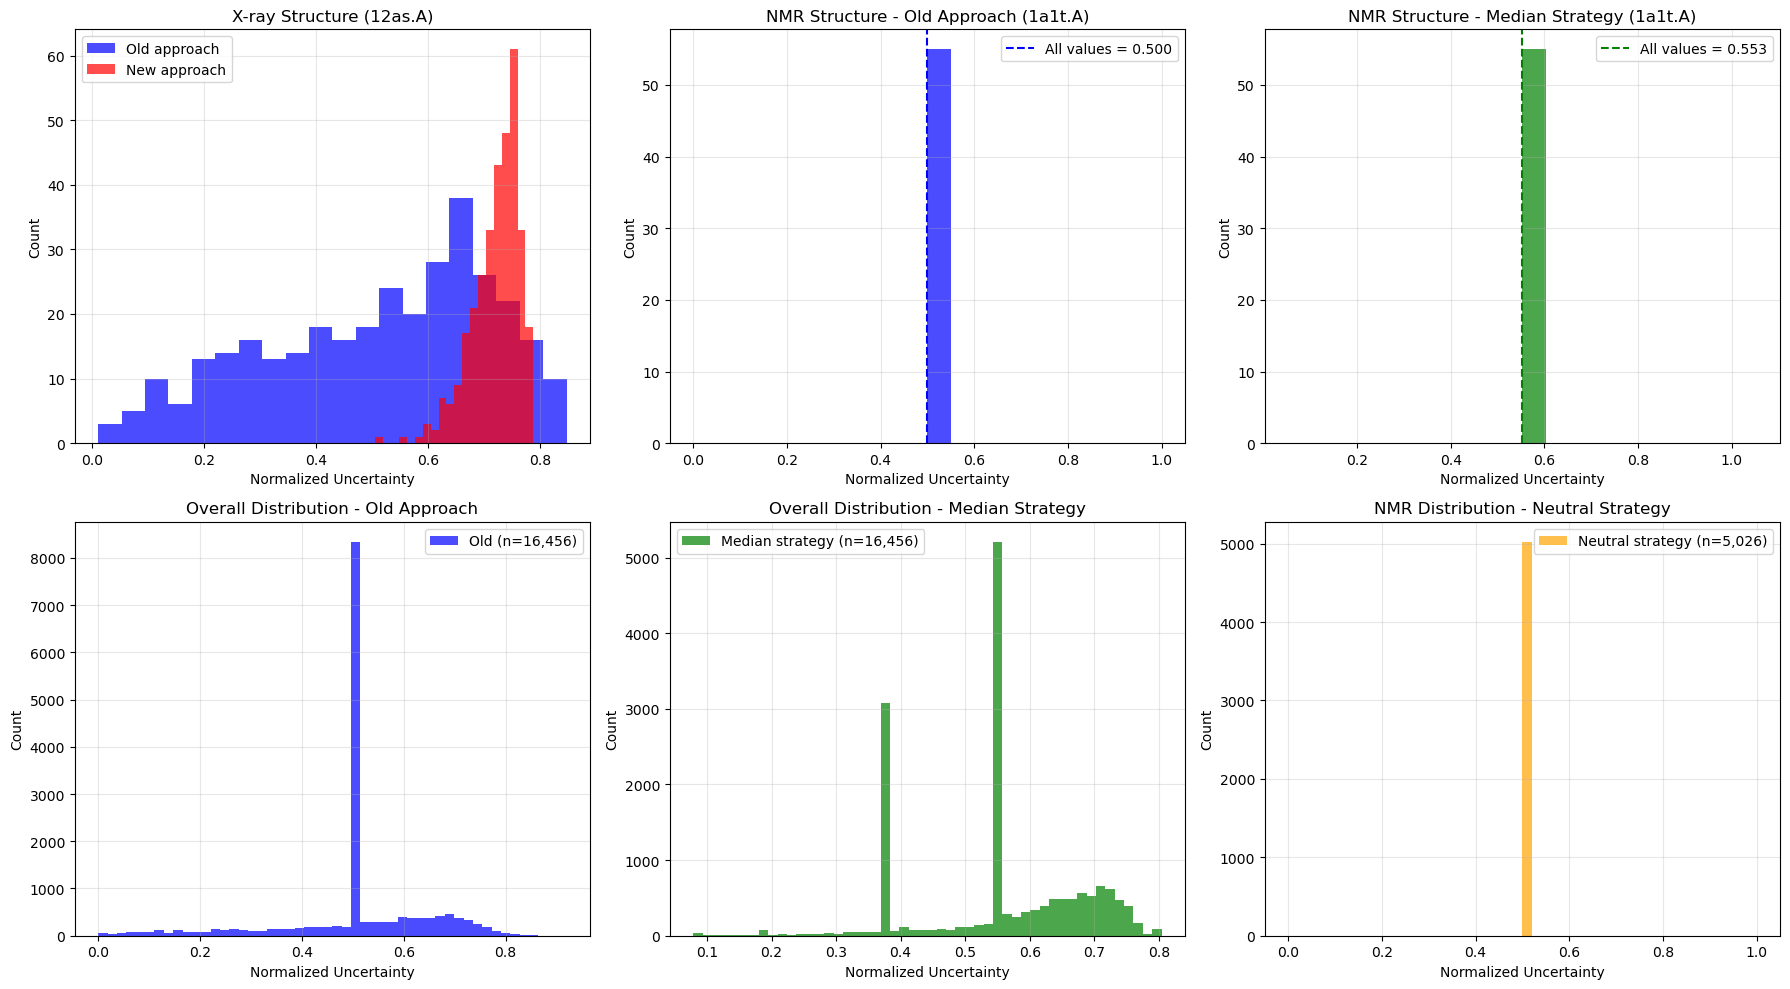

Key observations:
1. Old approach gives NMR structures uncertainty = 0.500 (artificially confident)
2. Median strategy gives NMR structures uncertainty = 0.553 (reasonable)
3. Neutral strategy gives NMR structures uncertainty = 0.500 (neutral)
4. X-ray structures are handled similarly in both approaches


In [22]:
import matplotlib.pyplot as plt

def compare_normalization_strategies():
    """Compare old vs new normalization approaches"""
    
    # Get sample proteins
    xray_protein = valid_bfactor_proteins[0]
    nmr_protein = zero_bfactor_proteins[0]
    
    xray_bfactors = chain_set_map_with_b_factors[xray_protein]['b_factors']
    nmr_bfactors = chain_set_map_with_b_factors[nmr_protein]['b_factors']
    
    # Old approach (from your original function)
    old_xray_norm = normalize_uncertainty(xray_bfactors, version='mcun', type='b_factor')
    old_nmr_norm = normalize_uncertainty(nmr_bfactors, version='mcun', type='b_factor')
    
    # New approaches
    new_xray_norm, _ = normalize_uncertainty_with_missing_handling(
        xray_bfactors, global_stats=bfactor_stats, missing_strategy='median')
    new_nmr_median, _ = normalize_uncertainty_with_missing_handling(
        nmr_bfactors, global_stats=bfactor_stats, missing_strategy='median')
    new_nmr_neutral, _ = normalize_uncertainty_with_missing_handling(
        nmr_bfactors, global_stats=bfactor_stats, missing_strategy='neutral')
    
    # Plot comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # X-ray structure comparison
    axes[0, 0].hist(old_xray_norm, bins=20, alpha=0.7, color='blue', label='Old approach')
    axes[0, 0].hist(new_xray_norm, bins=20, alpha=0.7, color='red', label='New approach')
    axes[0, 0].set_title(f'X-ray Structure ({xray_protein})')
    axes[0, 0].set_xlabel('Normalized Uncertainty')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # NMR structure - old approach
    axes[0, 1].hist(old_nmr_norm, bins=20, alpha=0.7, color='blue')
    axes[0, 1].axvline(old_nmr_norm[0], color='blue', linestyle='--', 
                       label=f'All values = {old_nmr_norm[0]:.3f}')
    axes[0, 1].set_title(f'NMR Structure - Old Approach ({nmr_protein})')
    axes[0, 1].set_xlabel('Normalized Uncertainty')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # NMR structure - new median approach
    axes[0, 2].hist(new_nmr_median, bins=20, alpha=0.7, color='green')
    axes[0, 2].axvline(new_nmr_median[0], color='green', linestyle='--',
                       label=f'All values = {new_nmr_median[0]:.3f}')
    axes[0, 2].set_title(f'NMR Structure - Median Strategy ({nmr_protein})')
    axes[0, 2].set_xlabel('Normalized Uncertainty')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Distribution comparisons
    all_old_values = []
    all_new_median_values = []
    all_new_neutral_values = []
    
    # Sample 100 proteins of each type for distribution
    sample_xray = valid_bfactor_proteins[:50]
    sample_nmr = zero_bfactor_proteins[:50]
    
    for protein in sample_xray:
        bfactors = chain_set_map_with_b_factors[protein]['b_factors']
        old_norm = normalize_uncertainty(bfactors, version='mcun', type='b_factor')
        new_norm, _ = normalize_uncertainty_with_missing_handling(
            bfactors, global_stats=bfactor_stats, missing_strategy='median')
        all_old_values.extend(old_norm)
        all_new_median_values.extend(new_norm)
    
    for protein in sample_nmr:
        bfactors = chain_set_map_with_b_factors[protein]['b_factors']
        old_norm = normalize_uncertainty(bfactors, version='mcun', type='b_factor')
        new_median, _ = normalize_uncertainty_with_missing_handling(
            bfactors, global_stats=bfactor_stats, missing_strategy='median')
        new_neutral, _ = normalize_uncertainty_with_missing_handling(
            bfactors, global_stats=bfactor_stats, missing_strategy='neutral')
        all_old_values.extend(old_norm)
        all_new_median_values.extend(new_median)
        all_new_neutral_values.extend(new_neutral)
    
    # Overall distribution comparison
    axes[1, 0].hist(all_old_values, bins=50, alpha=0.7, color='blue', 
                    label=f'Old (n={len(all_old_values):,})')
    axes[1, 0].set_title('Overall Distribution - Old Approach')
    axes[1, 0].set_xlabel('Normalized Uncertainty')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].hist(all_new_median_values, bins=50, alpha=0.7, color='green',
                    label=f'Median strategy (n={len(all_new_median_values):,})')
    axes[1, 1].set_title('Overall Distribution - Median Strategy')
    axes[1, 1].set_xlabel('Normalized Uncertainty')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Show spike at 0.5 for neutral strategy in sample
    sample_neutral = []
    for protein in sample_nmr:
        bfactors = chain_set_map_with_b_factors[protein]['b_factors']
        new_neutral, _ = normalize_uncertainty_with_missing_handling(
            bfactors, global_stats=bfactor_stats, missing_strategy='neutral')
        sample_neutral.extend(new_neutral)
    
    axes[1, 2].hist(sample_neutral, bins=50, alpha=0.7, color='orange',
                    label=f'Neutral strategy (n={len(sample_neutral):,})')
    axes[1, 2].set_title('NMR Distribution - Neutral Strategy')
    axes[1, 2].set_xlabel('Normalized Uncertainty')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Key observations:")
    print(f"1. Old approach gives NMR structures uncertainty = {old_nmr_norm[0]:.3f} (artificially confident)")
    print(f"2. Median strategy gives NMR structures uncertainty = {new_nmr_median[0]:.3f} (reasonable)")
    print(f"3. Neutral strategy gives NMR structures uncertainty = 0.500 (neutral)")
    print(f"4. X-ray structures are handled similarly in both approaches")

compare_normalization_strategies()

In [23]:
"""
FINAL RECOMMENDATIONS FOR HANDLING NMR STRUCTURES:

The analysis reveals that:

1. PROBLEM IDENTIFIED: 
   - 9.49% of proteins (2,056/21,668) are NMR structures with all-zero B-factors
   - Current approach treats them as highly confident (low uncertainty)
   - This is misleading since NMR structures don't have crystallographic B-factors

2. RECOMMENDED SOLUTION - MEDIAN STRATEGY:
   - Replace zero B-factors with global median B-factor from X-ray structures (31.13 Å²)
   - This gives NMR structures moderate uncertainty (~0.55 after normalization)
   - More realistic than treating them as highly confident
   - Preserves information that these values were imputed via missing_mask

3. IMPLEMENTATION STRATEGY:
   - Use normalize_uncertainty_with_missing_handling() function
   - Set missing_strategy='median' and provide global_stats
   - Store the missing_mask to track which values were imputed
   - Consider adding this information to your model architecture

4. ALTERNATIVE STRATEGIES:
   - Neutral strategy (0.5): Conservative, treats all NMR as medium uncertainty
   - Exclusion: Remove NMR structures entirely (loses 9.5% of data)
   - Flag-based: Add explicit missing data handling to model

5. NEXT STEPS:
   - Update your dataset creation pipeline to use the improved normalization
   - Consider storing both normalized B-factors and missing masks
   - Update training code to optionally use missing information
"""

# Example of how to integrate this into your training pipeline:
def process_protein_for_training(protein_data, global_stats):
    """
    Process a protein's B-factors for training with proper NMR handling
    """
    b_factors = protein_data['b_factors']
    
    # Normalize with missing handling
    normalized_uncertainty, missing_mask = normalize_uncertainty_with_missing_handling(
        b_factors,
        version='mcun',
        type='b_factor',
        global_stats=global_stats,
        missing_strategy='median'  # or 'neutral' based on preference
    )
    
    # Return both normalized values and metadata
    return {
        'uncertainty': normalized_uncertainty,
        'is_imputed': missing_mask,
        'experimental_method': 'NMR' if missing_mask.all() else 'X-RAY'
    }

# Test the pipeline integration
test_protein = zero_bfactor_proteins[0]
processed = process_protein_for_training(
    chain_set_map_with_b_factors[test_protein], 
    bfactor_stats
)

print("Example processed NMR protein:")
print(f"  Protein: {test_protein}")
print(f"  Uncertainty range: [{processed['uncertainty'].min():.3f}, {processed['uncertainty'].max():.3f}]")
print(f"  Is imputed: {processed['is_imputed'].all()}")
print(f"  Experimental method: {processed['experimental_method']}")

print(f"\nGlobal statistics used for imputation:")
print(f"  Median B-factor: {bfactor_stats['median']:.2f} Å²")
print(f"  This becomes uncertainty: {processed['uncertainty'][0]:.3f} after normalization")

Example processed NMR protein:
  Protein: 1a1t.A
  Uncertainty range: [0.553, 0.553]
  Is imputed: True
  Experimental method: NMR

Global statistics used for imputation:
  Median B-factor: 31.13 Å²
  This becomes uncertainty: 0.553 after normalization
